In [40]:
import numpy as np
import pandas as pd

In [ ]:
df = pd.read_csv("../data/processed/train_cleaned.csv")

In [42]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer

age_labels = ['Child', 'Teenager', 'Young Adult', 'Adult', 'Senior']

preprocessor = ColumnTransformer(transformers=[
    ('age_ord', OrdinalEncoder(categories=[age_labels]), ['AgeGroup']),
    ('cat_ohe', OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first'), ['Sex', 'Embarked', 'Title'])
], remainder='passthrough')

In [43]:
from sklearn.model_selection import train_test_split

X = df.drop('Survived', axis=1)
y = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [44]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

rfc = Pipeline([
    ('preprocessing', preprocessor),
    ('model', RandomForestClassifier(n_estimators=100, random_state=42))
])

rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.87      0.85      0.86       105
           1       0.79      0.82      0.81        74

    accuracy                           0.84       179
   macro avg       0.83      0.84      0.83       179
weighted avg       0.84      0.84      0.84       179



In [45]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(rfc, X, y, cv=5)
print(f"Accuracy on 5 folds: {scores}")

Accuracy on 5 folds: [0.81005587 0.76404494 0.85393258 0.75842697 0.84269663]


In [76]:
from sklearn.model_selection import GridSearchCV

params = {
    'model__n_estimators': [100, 200, 400],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_split': [2, 5, 10]
}

grid = GridSearchCV(estimator=rfc,
                    param_grid=params,
                    cv=5,
                    n_jobs=-1)
grid.fit(X_train, y_train)

rfc_best_model = grid.best_estimator_
y_pred = rfc_best_model.predict(X_test)

print(f"Best parameters found: {grid.best_params_}")
print(f"Best cross-validation accuracy: {grid.best_score_}")
print(classification_report(y_test, y_pred))

Best parameters found: {'model__max_depth': 10, 'model__min_samples_split': 5, 'model__n_estimators': 200}
Best cross-validation accuracy: 0.8314488328572835
              precision    recall  f1-score   support

           0       0.86      0.87      0.86       105
           1       0.81      0.80      0.80        74

    accuracy                           0.84       179
   macro avg       0.83      0.83      0.83       179
weighted avg       0.84      0.84      0.84       179



In [47]:
from xgboost import XGBClassifier

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

xgb_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', xgb)
])

xgb_params = {
    'model__n_estimators': [100, 200, 400],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__max_depth': [3, 5, 7],

}

xgb_grid = GridSearchCV(estimator=xgb_pipe,
                        param_grid=xgb_params,
                        cv=5,
                        n_jobs=-1,
                        scoring='accuracy')

xgb_grid.fit(X_train, y_train)
xgb_best_model = xgb_grid.best_estimator_
y_pred_xgb = xgb_best_model.predict(X_test)

print(f"XGBoost best params: {xgb_grid.best_params_}")
print(f"XGBoost best score: {xgb_grid.best_score_}")
print(classification_report(y_test, y_pred_xgb))

XGBoost best params: {'model__learning_rate': 0.01, 'model__max_depth': 3, 'model__n_estimators': 400}
XGBoost best score: 0.844085491972816
              precision    recall  f1-score   support

           0       0.82      0.89      0.85       105
           1       0.82      0.72      0.76        74

    accuracy                           0.82       179
   macro avg       0.82      0.80      0.81       179
weighted avg       0.82      0.82      0.81       179



c:\Users\Glisa\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:19:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


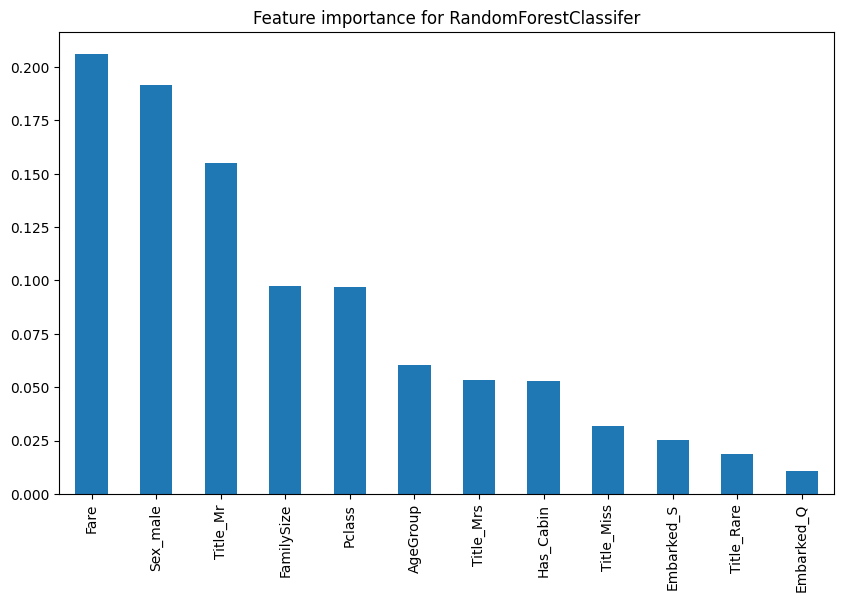

In [60]:
ohe_columns = xgb_best_model.named_steps['preprocessor'].named_transformers_['cat_ohe'].get_feature_names_out()
all_features = ['AgeGroup'] + list(ohe_columns) + ['Pclass', 'Fare', 'Has_Cabin', 'FamilySize']

import matplotlib.pyplot as plt

importance = rfc_best_model.named_steps['model'].feature_importances_
feature_importance = pd.Series(importance, index=all_features).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
feature_importance.plot(kind='bar')
plt.title('Feature importance for RandomForestClassifer')
plt.show()

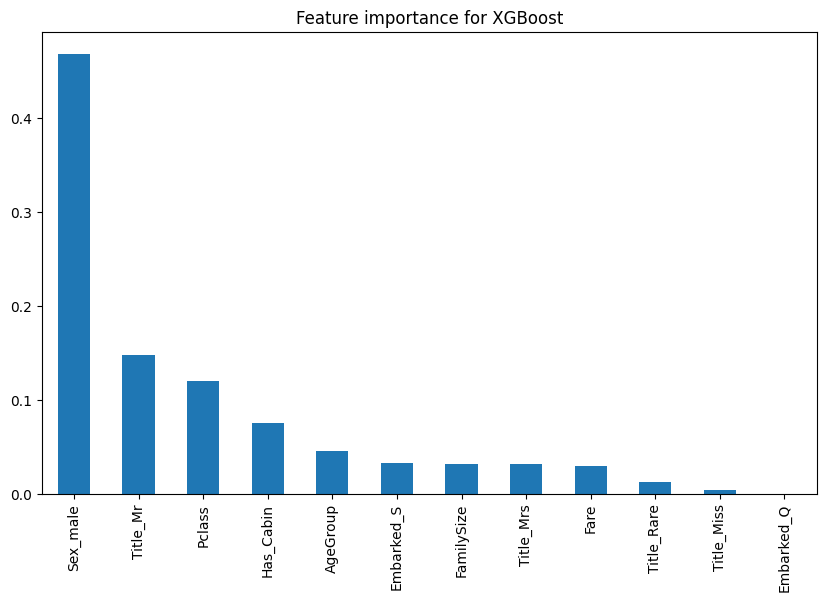

In [61]:
ohe_columns = xgb_best_model.named_steps['preprocessor'].named_transformers_['cat_ohe'].get_feature_names_out()
all_features = ['AgeGroup'] + list(ohe_columns) + ['Pclass', 'Fare', 'Has_Cabin', 'FamilySize']

import matplotlib.pyplot as plt

importance = xgb_best_model.named_steps['model'].feature_importances_
feature_importance = pd.Series(importance, index=all_features).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
feature_importance.plot(kind='bar')
plt.title('Feature importance for XGBoost')
plt.show()

In [63]:
import joblib
joblib.dump(rfc_best_model, 'titanic_rf_model.pkl')

['titanic_rf_model.pkl']

## Final model treaining

In [ ]:
final_model = rfc_best_model
final_model.fit(X, y)

test_data = pd.read_csv("../data/raw/test.csv")

In [71]:
test_data.drop(['PassengerId', 'Ticket'], axis=1, inplace=True)
test_data['Has_Cabin'] = test_data['Cabin'].notna().astype(int)
test_data.drop('Cabin', axis=1, inplace=True)

test_data['Title'] = test_data['Name'].str.extract(' ([A-Za-z]+)', expand=True)
common_titles = ['Mr', 'Miss', 'Mrs', 'Master']
test_data['Title'] = df['Title'].apply(lambda x: x if x in common_titles else 'Rare')
test_data.drop('Name', axis=1, inplace=True)

test_data['Age'] = test_data['Age'].fillna(test_data.groupby('Title')['Age'].transform('mean'))
test_data['Embarked'] = test_data['Embarked'].fillna(test_data['Embarked'].mode()[0])

test_data['FamilySize'] = test_data['Parch'] + test_data['SibSp'] + 1
test_data.drop(['Parch', 'SibSp'], axis=1, inplace=True)

bins = [0, 12, 18, 35, 60, 100]
age_labels = ['Child', 'Teenager', 'Young Adult', 'Adult', 'Senior']
test_data['AgeGroup'] = pd.cut(test_data['Age'], bins=bins, labels=age_labels)
test_data.drop('Age', axis=1, inplace=True)


In [72]:
predictions = final_model.predict(test_data)

In [ ]:
original_test = pd.read_csv('../data/raw/test.csv')

submission = pd.DataFrame({
    "PassengerId": original_test["PassengerId"],
    "Survived": predictions
})

submission.to_csv("../data/processed/final_submission.csv", index=False)